
# Cumulative V(A) as function of causal allele frequency

In [1]:
%matplotlib inline
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

/data/apps/user_contributed_software/krthornt/python/2.7.10/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#Mean effect sizes used in sims:
esizes=[0.1,0.25,0.5]

In [3]:
#Genetic models used:
models=['multi','additive','gbr']

In [4]:
#dominances used for multi:
dominance=[0.0,0.25,1.0]

In [5]:
def process_files(x):
    df=[pd.read_hdf(i) for i in x]
    for i in range(len(df)):
        df[i]['rep']=[i]*len(df[i].index)
    return pd.concat(df)
        

In [48]:
def makeplot(x,mname):
    if mname=='multi':
        return
    #fig=plt.figure()
    LT=['-','--',':']
    COLORS=['black','red','blue','purple','cyan','magenta']
    LTI=0
    CI=0
    print x.generation.unique()
    for e in x.esize.unique():
        fig=plt.figure(figsize=(10,5))
        for gen in x.generation.unique():
            xi=x[(x.generation==gen)&(x.esize==e)]
            N=xi.N.unique()[0]
            reps=xi.groupby(['rep'])
            totals=pd.Series([0.0]*(2*N))
            for rep in reps.groups:
                rep_i=reps.get_group(rep)
                rep_i.reset_index(inplace=True)
                rep_i.sort_values('freq')
                temp=pd.Series([0.0]*(2*N))
                for i in range(len(rep_i.index)):
                    row=rep_i.iloc[i]
                    idx=int(row['freq']*float(2*N))-1
                    temp[idx]+=row['pss']
                totals=totals.add(temp.cumsum())
            totals=totals.divide(float(len(xi.rep.unique())))
            plt.semilogx(np.arange(1.0/float(2*N),1.+1./float(2*N),1./float(2*N)),totals,
                         label=r'$t = $'+str(gen)+r',$N =$'+str(N),linestyle=LT[LTI],
                        color=COLORS[CI],linewidth=3)
            if LTI==len(LT)-1:
                LTI=0
            else:
                LTI+=1
            if CI==len(COLORS)-1:
                CI=0
            else:
                CI+=1
        if m == 'additive':
            plt.legend(loc='lower right')
        else:
            plt.legend(loc='upper left')
        plt.suptitle('Model = '+mname+r', $\lambda = $'+'{0:0.2}'.format(e))
        plt.ylim(0,1)
        plt.tight_layout()

[73100 76979 76980 78099 78100 79019]
[73100 76979 76980 78099 78100 79019]


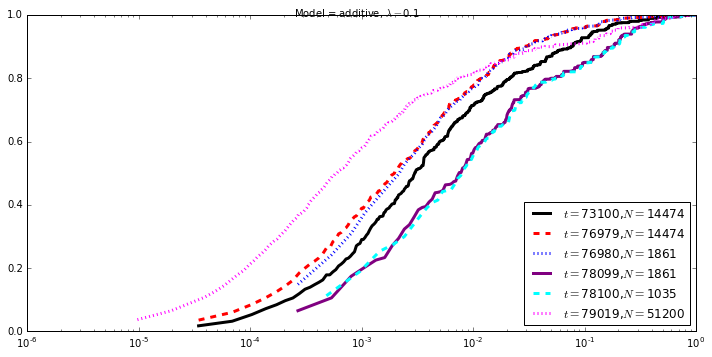

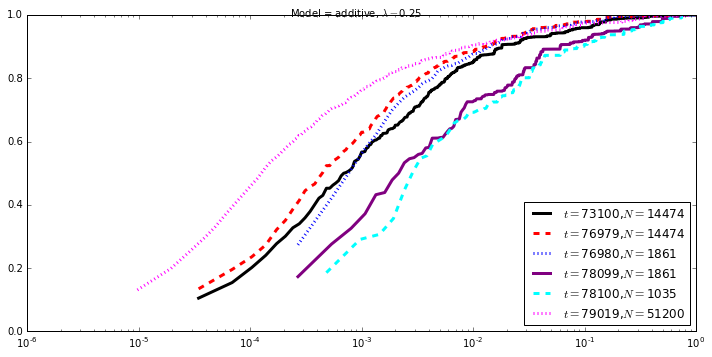

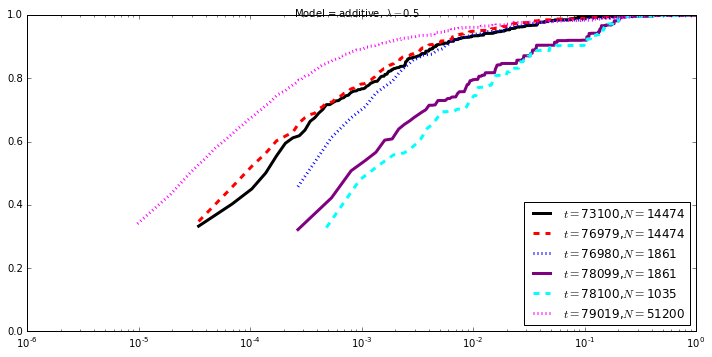

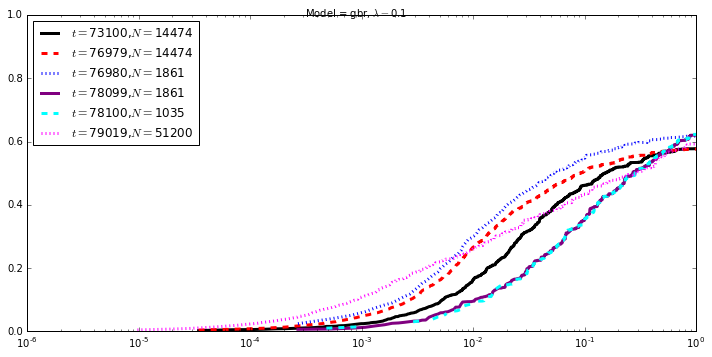

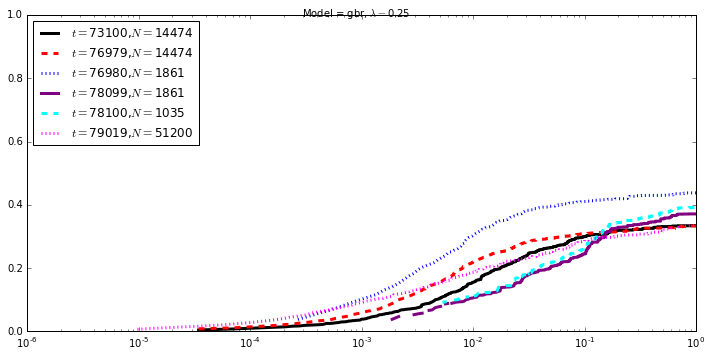

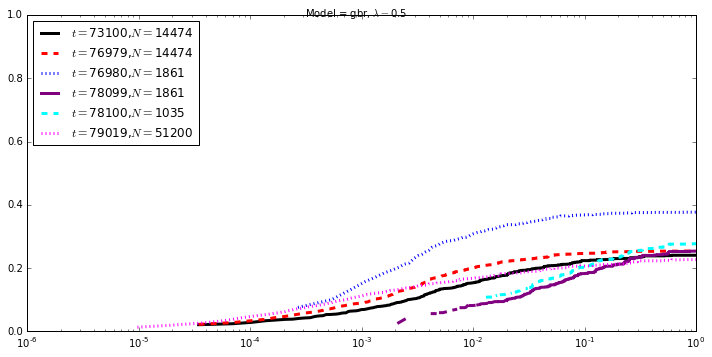

In [49]:
for m in models:
    bdf=[]
    for e in esizes:
        if m == 'multi':
            for h in dominance:
                pattern=m+r'.lambda'+'{0:0.2}'.format(e)+'.VA.h'+'{0:0.2}'.format(h)+r'.*.h5'
                #print pattern
                files=glob.glob(pattern)
                df=process_files(files)
                df['esize']=[e]*len(df.index)
                df['h']=[h]*len(df.index)
                bdf.append(df)
        else:
            pattern=m+r'.lambda'+'{0:0.2}'.format(e)+'.VA.*.h5'
            #print pattern
            files=glob.glob(pattern)
            df=process_files(files)
            df['esize']=[e]*len(df.index)
            bdf.append(df)
    BDF=pd.concat(bdf)
    makeplot(BDF,m)

# OK--so the exploratory plots are cool

Let's group by (effect size,model), plot different lines for each time, and then line styles by model?

In [73]:
#collect GBR data
BDFgbr=[]
m='gbr'
for e in esizes:
    pattern=m+r'.lambda'+'{0:0.2}'.format(e)+'.VA.*.h5'
    #print pattern
    files=glob.glob(pattern)
    df=process_files(files)
    df['esize']=[e]*len(df.index)
    BDFgbr.append(df)
BDFgbr=pd.concat(BDFgbr)


In [74]:
#collect additive data
BDFadd=[]
m='additive'
for e in esizes:
    pattern=m+r'.lambda'+'{0:0.2}'.format(e)+'.VA.*.h5'
    #print pattern
    files=glob.glob(pattern)
    df=process_files(files)
    df['esize']=[e]*len(df.index)
    BDFadd.append(df)
BDFadd=pd.concat(BDFadd)

In [162]:
def plot_details(sfig,xi,e,gen,style,C,label=True):
    N=xi.N.unique()[0]
    reps=xi.groupby(['rep'])
    totals=pd.Series([0.0]*(2*N))
    for rep in reps.groups:
        rep_i=reps.get_group(rep)
        rep_i.reset_index(inplace=True)
        rep_i.sort_values('freq')
        temp=pd.Series([0.0]*(2*N))
        for i in range(len(rep_i.index)):
            row=rep_i.iloc[i]
            idx=int(row['freq']*float(2*N))-1
            temp[idx]+=row['pss']
        totals=totals.add(temp.cumsum())
    totals=totals.divide(float(len(xi.rep.unique())))
    if label is True:
        sfig.semilogx(np.arange(1.0/float(2*N),1.+1./float(2*N),1./float(2*N)),totals,
                    label=r'$t = $'+str(gen)+r', $N =$'+str(N),linestyle=style,
                    color=C,linewidth=3)
    else:
        sfig.semilogx(np.arange(1.0/float(2*N),1.+1./float(2*N),1./float(2*N)),totals,
                    linestyle=style,
                    color=C,linewidth=3)
    
def plotAddGBR(a,g):
    LT=['-','--',':']

    #COLORS=['black','red','blue','purple','cyan','magenta']
    COLORS = [ plt.cm.viridis(x) for x in np.linspace(0.2,0.8, 6) ]
    LTI=0
    CI=0
    fig=plt.figure(figsize=(8.5,11))
    S3=plt.subplot2grid((3,1),(2,0))
    S1=plt.subplot2grid((3,1),(0,0),sharex=S3)
    S2=plt.subplot2grid((3,1),(1,0),sharex=S3)
   
    S=[S1,S2,S3]
    SI=0
    for e in a.esize.unique():
        for gen in a.generation.unique():
            xi=a[(a.generation==gen)&(a.esize==e)]
            
            plot_details(S[SI],xi,e,gen,LT[0],COLORS[CI])
            #Now, plot gbr data
            xi=g[(g.generation==gen)&(g.esize==e)]
            plot_details(S[SI],xi,e,gen,LT[1],COLORS[CI],False)                  
            if CI==len(COLORS)-1:
                CI=0
            else:
                CI+=1
        #if m == 'additive':
        #    plt.legend(loc='lower right')
        #else:
        if SI==0:
            S[SI].legend(loc='upper left',prop={'size':11})
        #plt.suptitle(
        S[SI].set_title(r'$\lambda = $'+'{0:0.2}'.format(e))
        S[SI].set_ylim(0,1)
        SI+=1
    plt.setp(S1.get_xticklabels(), visible=False)
    plt.setp(S2.get_xticklabels(), visible=False)
    S3.set_xlabel("Mutation frequency (log scale)")
    for ax in S:
        ax.set_ylabel("Cumulative % genetic variance")
    plt.tight_layout()
    fig.savefig('TennessenVA.pdf')

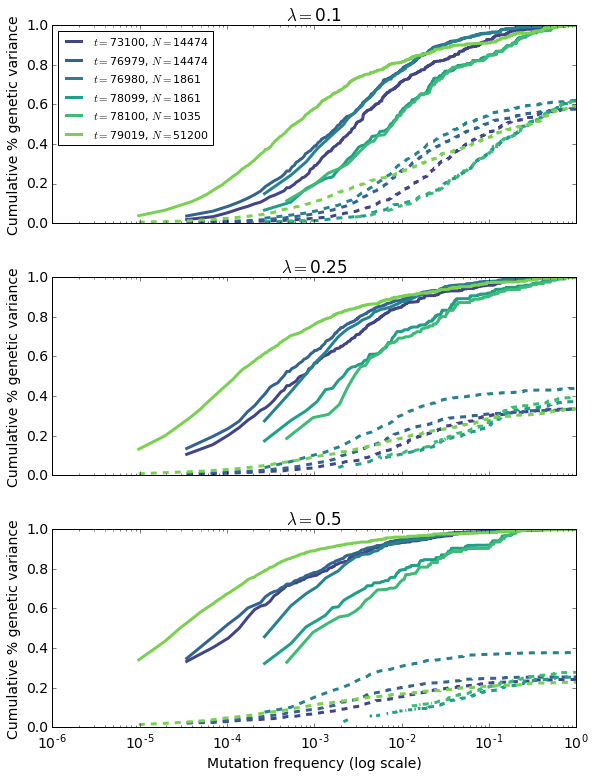

In [163]:
matplotlib.rcParams.update({'font.size': 14})

plotAddGBR(BDFadd,BDFgbr)